In [241]:
import numpy as np
import matplotlib.pyplot as plt

In [242]:
f_object = open("Train_Arabic_Digit.txt","r")
train_raw = f_object.read()
# 12 spaces separated
train_by_block_str = train_raw.split("\n            \n")
train_by_block_str[0] = train_by_block_str[0].lstrip()
train_by_block_str[-1] = train_by_block_str[-1].rstrip()

In [243]:
def mk_block_arr(block_string):
    frames_string = block_string.split("\n")
    frames_list = []
    for frame_string in frames_string:
        frames_list.append(np.fromstring(frame_string,sep = " "))
    
    block_array = np.array(frames_list)
    
    return block_array

train_by_block_arr = []
for train_block_str in train_by_block_str:
    train_by_block_arr.append(mk_block_arr(train_block_str))
# print(mk_block_arr(train_by_block[0]).shape)

In [419]:
# load test set
f_object_test = open("Test_Arabic_Digit.txt","r")
test_raw = f_object_test.read()
# 12 spaces separated
test_by_block_str = test_raw.split("\n            \n")
test_by_block_str[0] = test_by_block_str[0].lstrip()
test_by_block_str[-1] = test_by_block_str[-1].rstrip()

test_by_block_arr = []
test_by_block_arr_male = []
test_by_block_arr_female = []
for i,test_block_str in enumerate(test_by_block_str):
    temp = mk_block_arr(test_block_str)
    test_by_block_arr.append(temp)
    if i//110%2 == 0:
        test_by_block_arr_male.append(temp)
    else:
        test_by_block_arr_female.append(temp)

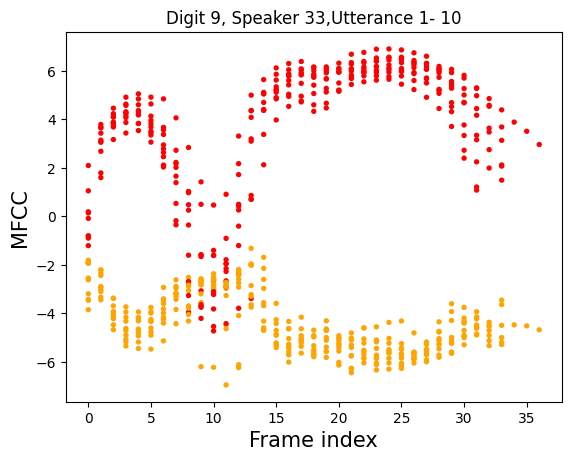

In [412]:
color_list = ["red","orange","yellow","green","blue","cyan","purple","black","grey","violet","maroon","olive","sienna"]
def plot_block_MFCC_windowi(block_array):

#     for i in range(block_array.shape[0]):
#         plt.scatter([i for j in range(13)],block_array[i,:],c = color_list,s = 8)
    for i in range(block_array.shape[0]):
        plt.scatter([i for j in range(2)],block_array[i,0:2],c = color_list[0:2],s = 8)
#         plt.scatter([i for j in range(2)],block_array[i,[8,12]],c = [color_list[i] for i in [8,12]],s = 8)

def plot_digit_MFCC_windowi(digit_list,digit,speaker):
    utterance = len(digit_list)
    for block in digit_list:
        plot_block_MFCC_windowi(block)
        
    plt.xlabel("Frame index",fontsize=15)
#     plt.ylim(-5,7)
    plt.ylabel("MFCC",fontsize=15)
    plt.title("Digit %d, Speaker %d,Utterance 1- %d"%(digit,speaker,utterance))
#     plt.title("Digit %d, Speaker %d,Utterance 1 MFCC8 12"%(digit,speaker),fontsize=15)
    plt.savefig("MFCC_Time_Digit%dSpeaker%dUtterance1-10-MFCC-0-2.png"%(digit,speaker))
plot_digit_MFCC_windowi(train_by_block_arr[6590:],9,33)
# plot_digit_MFCC_windowi(train_by_block_arr[0:1],0,1)


In [245]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

In [414]:
def MFCC_vectors_by_digit(digit,sample_ratio,MFCC_list,gender,train_flag = True):
    if train_flag:
        train_or_test_data = train_by_block_arr
        if gender=="all":
            digit_all_utterance = train_or_test_data[digit*660:(digit+1)*660-1]
        elif gender == "male":
            digit_all_utterance = train_or_test_data[digit*660:(digit+1)*660-330-1]
        elif gender == "female":
            digit_all_utterance = train_or_test_data[digit*660+330:(digit+1)*660-1]
    else:
        train_or_test_data = test_by_block_arr
        if gender=="all":
            digit_all_utterance = train_or_test_data[digit*220:(digit+1)*220-1]
        elif gender == "male":
            digit_all_utterance = train_or_test_data[digit*220:(digit+1)*220-110-1]
        elif gender == "female":
            digit_all_utterance = train_or_test_data[digit*220+110:(digit+1)*220-1]
    
    digit_all_utterance_concat = digit_all_utterance[0]
    for block in digit_all_utterance[1:]:
        digit_all_utterance_concat = np.concatenate((digit_all_utterance_concat,block),axis = 0)
    
    total_sample = digit_all_utterance_concat.shape[0]
    sample_row_idx = np.round(np.linspace(0, total_sample-1, round(total_sample*sample_ratio))).astype(int)
    digit_all_utterance_concat = digit_all_utterance_concat[sample_row_idx,:]
    digit_all_utterance_concat = digit_all_utterance_concat[:,MFCC_list]
    
#     print(digit_all_utterance_concat.shape)
    return digit_all_utterance_concat

# digit9 = MFCC_vectors_by_digit(9,1,[0,1,2,3,4,5,6,7,8,9,10,11,12],"all")
digit9 = MFCC_vectors_by_digit(9,1,[0,2],"all")
digit9_male = MFCC_vectors_by_digit(9,1,[0,2],"male")
digit9_female = MFCC_vectors_by_digit(9,1,[0,2],"female")

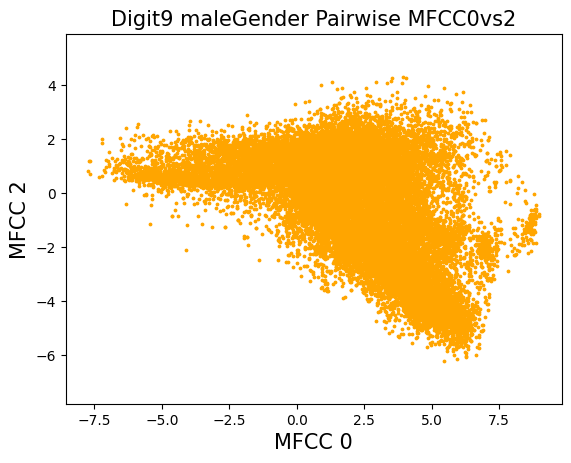

In [416]:
def plot_MFCC_pairwise(points,MFCC1,MFCC2,digit,labels,mode,gender,save_flag=True):
    plt.xlabel("MFCC %d"%MFCC1,fontsize=15)
    plt.ylabel("MFCC %d"%MFCC2,fontsize=15)
    plt.axis("equal")

#     plt.tight_layout()
    if mode=='plain':
        plt.title("Digit%d %sGender Pairwise MFCC%dvs%d"%(digit,gender,MFCC1,MFCC2),fontsize=15)
        plt.scatter(points[:,0],points[:,1],c=labels,label=labels,s=3)
        if save_flag:
            plt.savefig("Digit%d%sGenderPairwiseMFCC%dvs%d.png"%(digit,gender,MFCC1,MFCC2))
    elif mode=='kmeans':
        plt.title("Digit%d %sGender Pairwise with Kmeans MFCC%dvs%d"%(digit,gender,MFCC1,MFCC2),fontsize=15)
        plt.scatter(points[:,0],points[:,1],c=labels,label=labels,s=3)
        if save_flag:
            plt.savefig("Digit%d%sGenderPairwiseMFCC%dvs%dKmeans.png"%(digit,gender,MFCC1,MFCC2))
    elif mode =='em':
        plt.title("Digit%d %sGender Pairwise with EM MFCC%dvs%d"%(digit,gender,MFCC1,MFCC2),fontsize=15)
        for i in range(labels.shape[1]):
            plt.scatter(points[:,0],points[:,1], s=3,alpha=labels[:,i]) 
        if save_flag:
            plt.savefig("Digit%d%sGenderPairwiseMFCC%dvs%dEM.png"%(digit,gender,MFCC1,MFCC2))
    
plot_MFCC_pairwise(digit9_female,MFCC1=0,MFCC2=2,digit=9,labels='orange',mode='plain',gender='female',save_flag=True)
plot_MFCC_pairwise(digit9_male,MFCC1=0,MFCC2=2,digit=9,labels='orange',mode='plain',gender='male',save_flag=True)

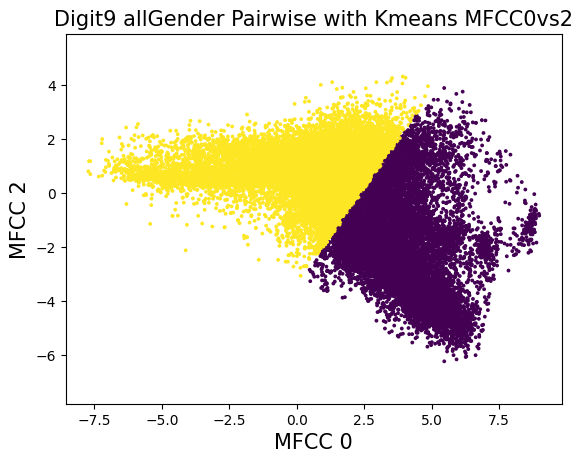

In [248]:
def k_means_cluster(points,n_clusters,digit,plot_flag = True):
    
    kmeans = KMeans(n_clusters=n_clusters,init="k-means++",n_init =10)
    kmeans.fit(points)

    labels = kmeans.labels_
    
    if plot_flag:
        plot_MFCC_pairwise(points,MFCC1=0,MFCC2=2,digit=digit,labels=labels,mode='kmeans',gender='all')

    return kmeans

k_means9 = k_means_cluster(digit9,2,9)
# k_means0 = k_means_cluster(digit0,2,0)

In [347]:
def estimate_cov(clusters,means,mode,tied_flag = True):
    n_clusters = len(clusters)
    cov_dim = means.shape[1]
    if tied_flag:
        #move clusters to center
        centered = np.subtract(clusters[0],means[0])
        
        for i in range(1,n_clusters):
            centered = np.concatenate((centered,clusters[i] - means[i]),axis=0)
      
        if mode == "spherical":
            variance = np.sum(np.square(centered))/(n_clusters*centered.shape[0])
            cov = variance*np.identity(cov_dim)
            cov = np.repeat(cov[np.newaxis, :, :], n_clusters, axis=0)
        
        elif mode == "diag":
            variances = np.sum(np.square(centered),axis=0)/(centered.shape[0])
            cov = np.diag(variances)
            cov = np.repeat(cov[np.newaxis, :, :], n_clusters, axis=0)
            
        elif mode == "full":
            cov = np.cov(centered.T)
            cov = np.repeat(cov[np.newaxis, :, :], n_clusters, axis=0)
    else:
        cov = np.zeros((n_clusters,cov_dim,cov_dim))
        for i in range(n_clusters):
            if mode == "spherical":
                variance = np.sum(np.square(np.subtract(clusters[i],means[i])))/(n_clusters*clusters[i].shape[0])
                cov_cluster = variance*np.identity(cov_dim)
                cov[i,:,:] = cov_cluster

            elif mode == "diag":     
                variances = np.sum(np.square(np.subtract(clusters[i],means[i])),axis = 0)/clusters[i].shape[0]
                cov_cluster = np.diag(variances)
                cov[i,:,:] = cov_cluster
                
            elif mode == "full":
                cov[i,:,:] = np.cov(clusters[i].T)
                
        if mode == "spherical":
            cov_vec = np.zeros(n_clusters)
            for i in range(n_clusters):
                variance = np.sum(np.square(np.subtract(clusters[i],means[i])))/(n_clusters*clusters[i].shape[0])
                cov_vec[i] = variance

        elif mode == "diag":     
            cov_vec = np.zeros((n_clusters,cov_dim))
            for i in range(n_clusters):
                variances = np.sum(np.square(np.subtract(clusters[i],means[i])),axis = 0)/clusters[i].shape[0]
                cov_vec[i,:] = variances

        elif mode == "full":
            cov_vec = np.zeros((n_clusters,cov_dim,cov_dim))
            for i in range(n_clusters):
                cov_vec[i,:,:] = np.cov(clusters[i].T)
                
    return cov

In [250]:
def into_clusters(n_clusters,points,labels):
    clusters = [[] for i in range(n_clusters)]
    for i in range(len(points)):
        clusters[labels[i]].append(points[i])
    
    lens = np.zeros(len(clusters))
    for i in range(len(clusters)):
        lens[i] = len(clusters[i])
        clusters[i] = np.asarray(clusters[i])
        
    return clusters,lens


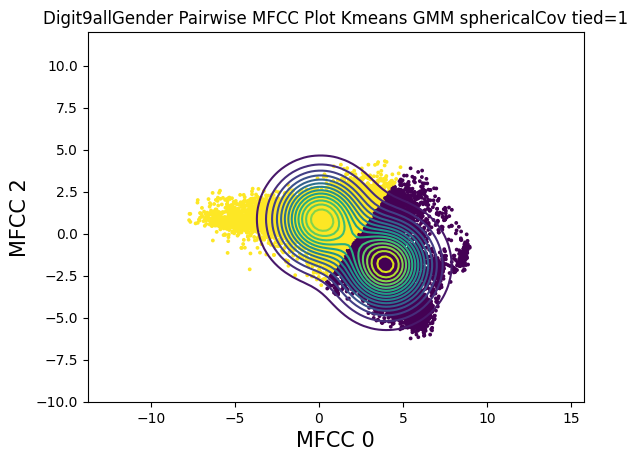

In [257]:
def visualize_GMM_kmeans(kmeans_obj,points,cov_mode,tied_flag,digit,gender):

    means = kmeans_obj.cluster_centers_
    labels = kmeans_obj.labels_
    n_clusters = kmeans_obj.n_clusters
    clusters,lens = into_clusters(n_clusters,points,labels) 

    covariances = estimate_cov(clusters,means,cov_mode,tied_flag)

    weights = lens/np.sum(lens)
    x = np.linspace(-10,12,100)
    y = np.linspace(-10,12,100)
    xv,yv = np.meshgrid(x,y)

    grid = np.stack((xv,yv),axis=-1)
    pdf = np.zeros((100,100))
    for i in range(len(weights)):
        if tied_flag:
            pdf += weights[i]*multivariate_normal.pdf(grid,means[i],covariances)
        else:
            pdf += weights[i]*multivariate_normal.pdf(grid,means[i],covariances[i])
    MFCC1=0
    MFCC2=2
    plot_MFCC_pairwise(points,MFCC1=MFCC1,MFCC2=MFCC2,digit=9,labels=labels,mode='kmeans',gender=gender,save_flag=False)
    plt.title("Digit%d%sGender Pairwise MFCC Plot Kmeans GMM %sCov tied=%d"%(digit,gender,cov_mode,tied_flag),fontsize=12)
    plt.contour(grid[:,:,0],grid[:,:,1],pdf,15)
#     plt.tight_layout()
    
    plt.savefig("GMMDigit%d%sGenderPairwiseMFCC%dvs%dKmeans%stied%d.png"%(digit,gender,MFCC1,MFCC2,cov_mode,tied_flag))

visualize_GMM_kmeans(k_means9,digit9,"spherical",True,9,'all')


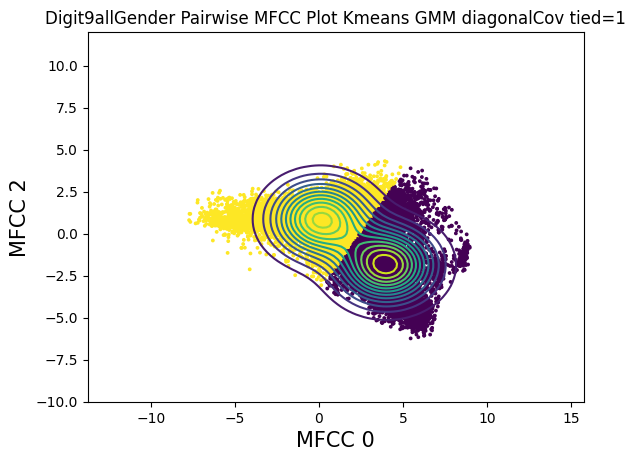

In [258]:
visualize_GMM_kmeans(k_means9,digit9,"diag",True,9,'all')

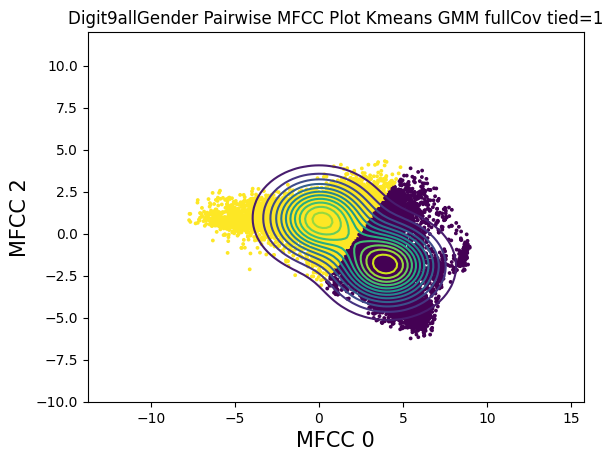

In [259]:
visualize_GMM_kmeans(k_means9,digit9,"full",True,9,'all')

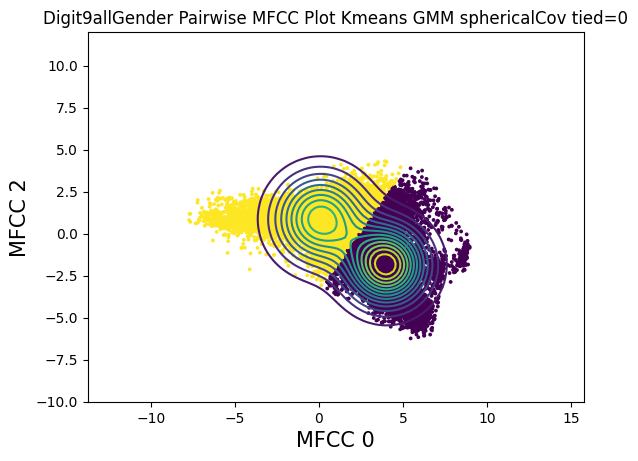

In [260]:
visualize_GMM_kmeans(k_means9,digit9,"spherical",False,9,'all')

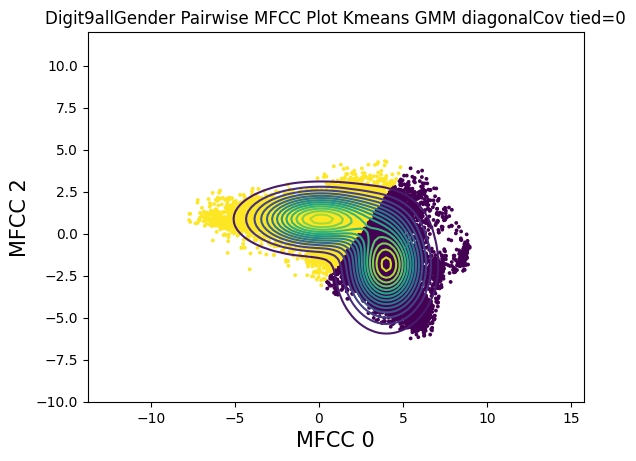

In [261]:
visualize_GMM_kmeans(k_means9,digit9,"diag",False,9,'all')

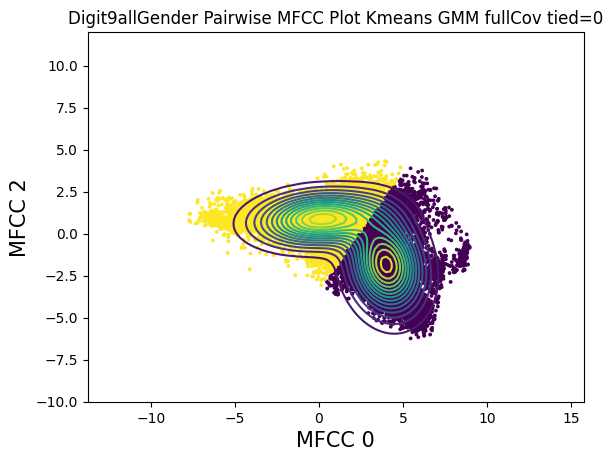

In [262]:
visualize_GMM_kmeans(k_means9,digit9,"full",False,9,'all')

In [146]:
def EM_cluster(points,n_clusters,cov_mode,digit,plot_flag=True):
    n_samples = points.shape[0]
    gm = GaussianMixture(n_components = n_clusters, covariance_type = cov_mode,random_state = 10086)
    gm.fit(points)
    means = gm.means_
    weights = gm.weights_
    covs = gm.covariances_
    densities = gm.predict_proba(points)
    responsibilities = np.divide(np.multiply(weights,densities),np.dot(densities,weights).reshape(n_samples,1))
    
    if plot_flag:
        plot_MFCC_pairwise(points,MFCC1=0,MFCC2=2,digit=digit,labels=responsibilities,mode='em',gender='all')
    
    return (gm,responsibilities)
    
gm9,responsibilities9 = EM_cluster(digit9,2,'full',9,False)  

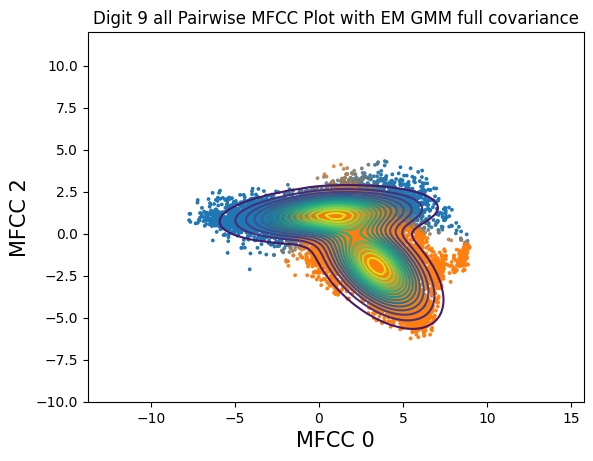

In [147]:
def visualize_GMM_EM(EM_obj,responsibilities,points,digit,gender):
    means = EM_obj.means_
    labels = EM_obj.predict(points)
    # put into clusters
    clusters,lens = into_clusters(EM_obj.n_components,points,labels)
    covariances = EM_obj.covariances_
    weights = EM_obj.weights_
    x = np.linspace(-10,12,100)
    y = np.linspace(-10,12,100)
    xv,yv = np.meshgrid(x,y)

    grid = np.stack((xv,yv),axis=-1)
    pdf = np.zeros((100,100))
    for i in range(len(weights)):
        pdf += weights[i]*multivariate_normal.pdf(grid,means[i],covariances[i])
    MFCC1=0
    MFCC2=2
    plot_MFCC_pairwise(points,MFCC1=MFCC1,MFCC2=MFCC2,digit=9,labels=responsibilities,mode='em',gender='all',save_flag=False)
    plt.title("Digit %d %s Pairwise MFCC Plot with EM GMM %s covariance"%(digit,gender,EM_obj.covariance_type))
    plt.contour(grid[:,:,0],grid[:,:,1],pdf,15)
    plt.savefig("GMMDigit%d%sGenderPairwiseMFCC%dvs%dEM.png"%(digit,gender,MFCC1,MFCC2))
visualize_GMM_EM(gm9,responsibilities9,digit9,9,'all')

In [343]:
def into_cov_vec(cov,cov_mode):
    n_clusters = cov.shape[0]
    cov_dim = cov.shape[1]
    if cov_mode == "spherical":
        cov_vec = np.zeros(n_clusters)
        for i in range(n_clusters):
            cov_vec[i] = np.diag(cov[i])[0]
    elif cov_mode == "diag":
        cov_vec = np.zeros((n_clusters,cov_dim))
        for i in range(n_clusters):
            cov_vec[i,:] = np.diag(cov[i])
    elif cov_mode == "full":
        cov_vec = cov
        
    return cov_vec
         

In [423]:
# get 1 GMM for each digit
# how we obtain the parameters for GMMs depend on our modeling choice
# compute likelihood for each digit, take the max likelihood

def generate_models(expected_n_component,MFCC_list,sample_ratio,gender,cov_mode,tied_flag):
    digits_data = []
    
    kmeans_objs = []
    em_objs = []
    kmeans_gmm = []
    for i in range(10):
        temp_digit_data = MFCC_vectors_by_digit(i,sample_ratio,MFCC_list,gender)
        print(temp_digit_data.shape)
        digits_data.append(temp_digit_data)
        
        kmeans_objs.append(k_means_cluster(temp_digit_data,expected_n_component[i],i,False))
        em_objs.append(EM_cluster(temp_digit_data,expected_n_component[i],cov_mode,i,False)[0])

        clusters,lens = into_clusters(expected_n_component[i],digits_data[i],kmeans_objs[i].labels_)
        temp_gmm = GaussianMixture(n_components=expected_n_component[i],covariance_type=cov_mode)
        temp_gmm.means_ = kmeans_objs[i].cluster_centers_
        temp_gmm.weights_ = lens/np.sum(lens)

        cov = estimate_cov(clusters,temp_gmm.means_,cov_mode,tied_flag)
        temp_gmm.covariances_ = into_cov_vec(cov,cov_mode)
    
        cov_inv = np.linalg.inv(cov)
        temp_gmm.precisions_ = into_cov_vec(cov_inv,cov_mode)
        temp_gmm.precisions_cholesky_ = into_cov_vec(np.linalg.cholesky(cov_inv),cov_mode)

        kmeans_gmm.append(temp_gmm)
        
    return (digits_data,kmeans_gmm,em_objs)
MFCC_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
# digits_data,kmeans_gmm,em_gmm = generate_models([2,2,3,3,3,2,2,2,3,2],[0,1,2,3,4,5,6,7,8,9,10,11,12],1,'all','full',False)
# digits_data,kmeans_gmm,em_gmm = generate_models([2,2,3,3,3,2,2,2,3,2],[0,1,2,3,4,5,6,7,8,9],1,'all','full',False)
digits_data,kmeans_gmm,em_gmm = generate_models([2,2,3,3,3,2,2,2,3,2],MFCC_list,1,'male','full',False)

(11528, 13)
(10756, 13)
(12924, 13)
(13958, 13)
(12958, 13)
(10352, 13)
(13966, 13)
(12205, 13)
(15493, 13)
(11391, 13)


In [424]:
def compute_loglikelihood(test_data,gmm,MFCC_list):
    test_data = test_data[:,MFCC_list]
    
    likelihood = np.zeros(10)
    n_frames = test_data.shape[0]
    for i in range(10):
        likelihood[i] = gmm[i].score(test_data)*n_frames
        
    return likelihood

compute_loglikelihood(test_by_block_arr[0],kmeans_gmm,MFCC_list)


array([ -391.96934423,  -726.23213803,  -783.87851863,  -788.93692485,
       -1034.60617944,  -501.50320988,  -389.30351563,  -452.08123572,
        -977.03778579,  -456.47362085])

In [426]:
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay

def model_predict(test_data,gmm,MFCC_list):
    
    predictions = []
    for block in test_data:   
        predictions.append(np.argmax(compute_loglikelihood(block,gmm,MFCC_list)))
        
    return predictions

# kmeans_predictions = model_predict(test_by_block_arr,kmeans_gmm,MFCC_list)
# em_predictions = model_predict(test_by_block_arr,em_gmm,MFCC_list)
# ground_truth = [i//220 for i in range(2200)]

kmeans_predictions = model_predict(test_by_block_arr_female,kmeans_gmm,MFCC_list)
em_predictions = model_predict(test_by_block_arr_female,em_gmm,MFCC_list)
ground_truth = [i//110 for i in range(1100)]

kmeans_acc = accuracy_score(ground_truth,kmeans_predictions)
em_acc = accuracy_score(ground_truth,em_predictions)
print(kmeans_acc)
print(em_acc)

0.610909090909091
0.48454545454545456


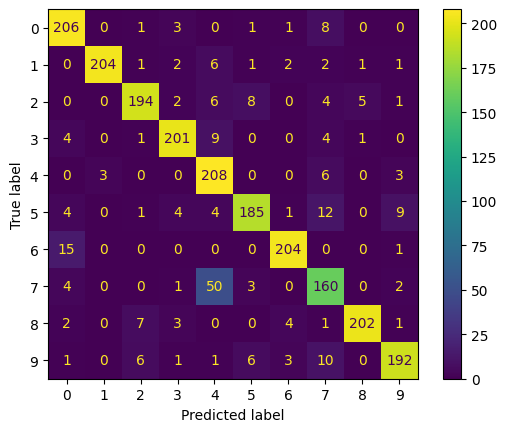

In [341]:
cm_kmeans = confusion_matrix(ground_truth,kmeans_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
# plt.savefig("full-gmm-kmeans.png")

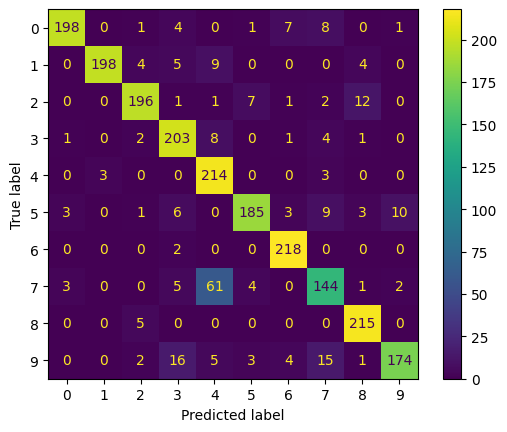

In [155]:
cm_em = confusion_matrix(ground_truth,em_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_em)

disp.plot()
# plt.show()
plt.savefig("full-gmm-em.png")